In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import gc
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Step 1: Data Exploration and Understanding


# Load the dataset
df = pd.read_csv(r'D:\ranjiny\Guvi_python\capstone_microsoft\GUIDE_Train.csv')

# Initial inspection
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [3]:
def Top_3_Cate(A):
    
    top_3_categories = df[A].value_counts().nlargest(3).index

    # Step 2: Replace other categories with 'rest'
    df[A] = df[A].apply(lambda x: x if x in top_3_categories else 'Others')
    return A

def data_preprocessing(df):
    #Step 2a:Handling Missing Data
    #drop columns with null values
    df.drop(columns=['MitreTechniques','ActionGrouped','ActionGranular','EmailClusterId','ThreatFamily','ResourceType','Roles','SuspicionLevel'
                    ,'AntispamDirection','LastVerdict'],axis=1,inplace=True)
    df.drop(columns=['EvidenceRole','DeviceId','EntityType','ApplicationName','ApplicationId','RegistryKey'
                     ,'OSVersion','OSFamily','ResourceIdName','RegistryValueData','RegistryValueName'
                     ,'OAuthApplicationId','FolderPath','State','City'],axis=1,inplace=True)

    #drop null values for df.dropna(inplace=True)
    df.dropna(inplace=True)

    #Step 2b:Feature Engineering

    # Convert timestamps to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Extract features from the timestamp and drop it
    #df['Hour'] = df['Timestamp'].dt.hour
    df['Day_of_week'] = df['Timestamp'].dt.dayofweek.astype('int8')

    df.drop(columns=['Timestamp'],axis=1,inplace=True)
    
    gc.collect()

    for col in ['Category','CountryCode']:
        Top_3_Cate(col)
   

   #Step 2c:Encoding Categorical Variables: 
    from sklearn.preprocessing import LabelEncoder

    # One-Hot Encoding
    df = pd.get_dummies(df, columns=['Category','CountryCode'],dtype='int8',drop_first=True)
    #df = pd.get_dummies(df, columns=['EntityType', 'EvidenceRole', 'DeviceId', 'CountryCode', 'State', 'City'],dtype='int')
    gc.collect()
    # Label encoding
    model = LabelEncoder()

    for col in (['Id','OrgId','IncidentId','AlertId','DetectorId','AlertTitle','Sha256','IpAddress','Url','AccountSid'
                ,'AccountUpn','AccountObjectId','AccountName','DeviceName','NetworkMessageId'
                ,'FileName','IncidentGrade']):
        df[col] = model.fit_transform(df[col])

    gc.collect()

    return df

In [ ]:
df=data_preprocessing(df)

#Step 3:Data Splitting 
gc.collect()


X = df.drop(columns=['IncidentGrade'],axis=1)  # Drop output column 
y = df['IncidentGrade']

#Step 3a: Train-Validation Split & Step 3b: Stratification
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.3,stratify=y, random_state=42)
gc.collect()

0

In [5]:
def model_metrics(y_input,y_pred):
    #print("*******Train******")
    print(f"Accuracy: {accuracy_score(y_input,y_pred)}")
    print(f"Precision: {precision_score(y_input,y_pred,average='macro')}")
    print(f"Recall : {recall_score(y_input,y_pred,average='macro')}")
    print(f"F1 Score: {f1_score(y_input,y_pred,average='macro')}")
    # Calculate the confusion matrix
    cm = confusion_matrix(y_input, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for train")
    plt.show()
    return

Cross validation score:[0.98991443 0.98998679 0.98999418 0.99011251 0.98989382]
*******Train******
Accuracy: 0.9999990944553957
Precision: 0.9999985939089542
Recall : 0.9999991950680777
F1 Score: 0.9999988944867463


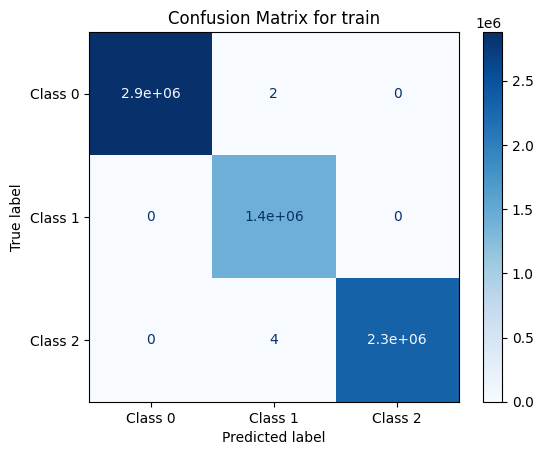

*******Test******
Accuracy: 0.9883327170602011
Precision: 0.9880036769056394
Recall : 0.9868433589624018
F1 Score: 0.9874140901405731


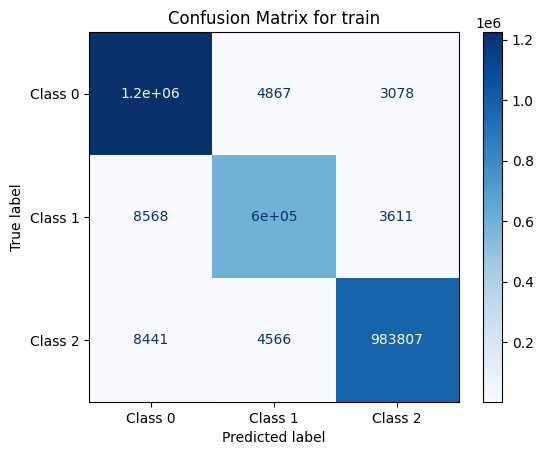

In [ ]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
cvs=cross_val_score(model,X,y,cv=5)
print(f"Cross validation score:{cvs}")

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
print("*******Train******")
model_metrics(y_train,train_pred)
print("*******Test******")
model_metrics(y_test,test_pred)
gc.collect()

In [7]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Saving the model in pickle format
import pickle

with open("Capstone_4.pkl",'wb') as file:
    pickle.dump(model,file)
gc.collect()

In [ ]:
#Step 7: Final Evaluation on Test Set
#Training dataset
df = pd.read_csv(r'D:\ranjiny\Guvi_python\capstone_microsoft\GUIDE_Test.csv')
print(df.head(10))
df.drop(columns=['Usage'],axis=1,inplace=True)
df=data_preprocessing(df)

              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0  1245540519230    657       11767    87199  2024-06-04T22:56:27.000Z   
1  1400159342154      3       91158   632273  2024-06-03T12:58:26.000Z   
2  1279900255923    145       32247   131719  2024-06-08T03:20:49.000Z   
3    60129547292    222       15294   917686  2024-06-12T12:07:31.000Z   
4   515396080539    363        7615     5944  2024-06-06T17:42:05.000Z   
5   670014899930      0         238   378946  2024-06-06T08:10:50.000Z   
6  1194000913330    133      105333   732769  2024-06-15T04:06:55.000Z   
7   678604832796      6        2461     1523  2024-05-26T11:48:38.000Z   
8   618475292265      7        5177     1815  2024-05-25T17:57:20.000Z   
9   438086667998    100        7060     9787  2024-06-02T05:46:22.000Z   

   DetectorId  AlertTitle            Category  \
0         524         563     LateralMovement   
1           2           2   CommandAndControl   
2        2932       10807     LateralM

Accuracy: 0.8126300629316546
Precision: 0.8164884366677265
Recall : 0.7760404184971149
F1 Score: 0.7878361490102618


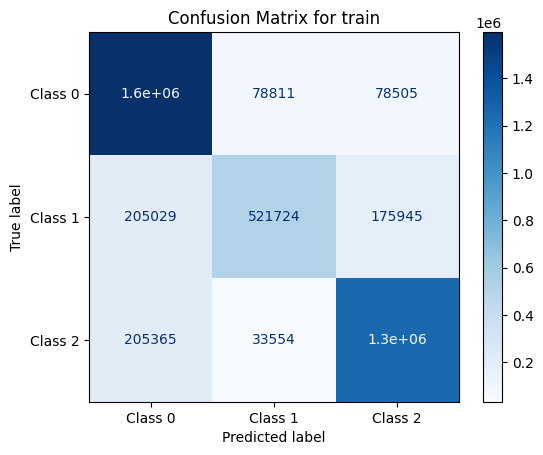

In [11]:
x_test= df.drop(columns=['IncidentGrade'],axis=1)  # Drop output column 
y_test = df['IncidentGrade']


with open("Capstone_4.pkl",'rb') as file:
    loaded_model=pickle.load(file)

test_pred = loaded_model.predict(x_test)
model_metrics(y_test,test_pred)


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85   1752940
           1       0.82      0.58      0.68    902698
           2       0.83      0.84      0.84   1492354

    accuracy                           0.81   4147992
   macro avg       0.82      0.78      0.79   4147992
weighted avg       0.81      0.81      0.81   4147992



In [ ]:

#Step 6:Model Interpretation:
#Step 6 a :Feature Importance:
# Get feature importance
#importances = model.feature_importances_

# Create a DataFrame to view the feature importances
features = pd.DataFrame({
    'Feature': x_test.columns,
    'Importance': loaded_model.feature_importances_
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

print(features)

                        Feature  Importance
1                         OrgId    0.239413
2                    IncidentId    0.156459
4                    DetectorId    0.115291
3                       AlertId    0.109233
5                    AlertTitle    0.090902
0                            Id    0.047481
29       Category_InitialAccess    0.025875
28                  Day_of_week    0.022919
11                   AccountUpn    0.022243
10                   AccountSid    0.016247
12              AccountObjectId    0.015505
8                     IpAddress    0.015339
13                  AccountName    0.012875
15             NetworkMessageId    0.011819
40              CountryCode_242    0.010861
14                   DeviceName    0.008807
9                           Url    0.007926
30              Category_Others    0.007884
22                     FileName    0.007322
7                        Sha256    0.006761
23                   FolderPath    0.006671
27                         City 